<center><font size="7"><b>Preprocessing</b></font></center>

## This notebook will focus on preparation of the dataset for training. The content of this notebook is as follows:
* We will begin with loading images and plotting graph to view image size distribution,
* Then image tagging will be performed and discussed,
* After generation of tags is finished a data split will be done to separate training data from images that will be used to test the model,
* With our newly created sets we will generate TF record files that will be used for training.

## <b>1. Install all modules needed for the project to work - Please restart the kernel to update seaborn for this notebook</b>

In [2]:
# Update seaborn library as its 0.11 is required to display the graph in section 4.2
import seaborn as sns
if "11" not in sns.__version__:
    !pip install seaborn -U
# Library for renom_tag
!pip install bottle
# Library loading images as array
!pip install imageio
# Library for image augmentation
!pip install imgaug
# Library for renom_tag
!pip install glob2

## <b>2. Import modules required for this notebook</b>

In [1]:
import os
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.pyplot import imread
import matplotlib.pyplot as plt
from IPython.display import Image

## <b>3. Get paths for directories that will be used further in the code</b>

In [2]:
# Do not run this again if you run any of the "cd" commands later in the notebook because you will overwrite your home directory path
cur_dir = os.getcwd()

In [3]:
main_dir = os.path.dirname(cur_dir)
figures_dir = os.path.join(main_dir, "figures")
scripts_dir = os.path.join(main_dir, "scripts")
work_dir = os.path.join(main_dir, "public/Birds")
detect_dir = os.path.join(work_dir, "label", "detection")
data_dir = os.path.join(work_dir, "dataset")
augment_dir = os.path.join(work_dir, "augment")
augxm_dir = os.path.join(work_dir, "augment", "xml")
augim_dir = os.path.join(work_dir, "augment", "image")

## <b> 4. EDA</b>

### <b> 4.1 Load dimensions of images for analysis</b>

In [4]:
data = []

for filename in os.listdir(data_dir):
    name, ext = os.path.splitext(filename)
    try:
        img = imread(os.path.join(data_dir, filename))
        height, width, color = img.shape
        t = ""
        if "Erithacus" in filename:
            t = "Erithacus_Rubecula"
        elif "Periparus" in filename:
            t = "Periparus_ater"
        elif "Pica" in filename:
            t = "Pica_pica"
        else:
            t = "Turdus_merula"
        data.append([height, width, t])      
    except:
        continue

### <b>4.2 Plot images dimensions to see size distribution of images in dataset</b>
#### As we can see on the graph majority of the pictures have width values in between 950 and 1024 pixels. Height on the other hand has two major groups: 600 to 800 pixels and 950 to 1024 pixels. This observation can help determine resize values to standardize images without distorting them. 

In [5]:
df = pd.DataFrame(data=data, columns=["height", "width", "species"])

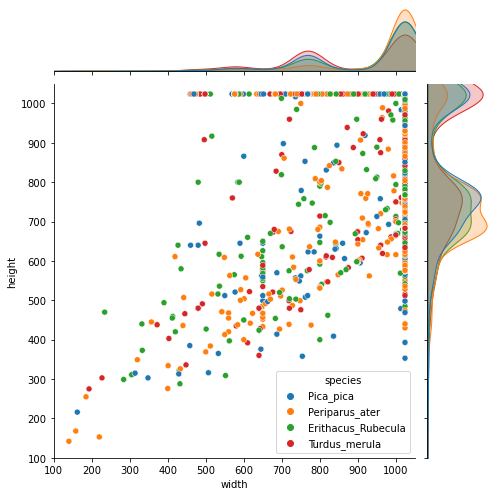

In [6]:
plot = sns.jointplot(data=df, x="width", y="height", hue="species", xlim=(100, 1050), ylim=(100, 1050), height=7)
plot.ax_joint.set_xticks([i for i in range(100, 1100, 100)])
plot.ax_joint.set_yticks([i for i in range(100, 1100, 100)]);

### <b>4.3 More information about pictures.</b>
#### We can see substantial difference between minimum and maximum resolution values. Images cannot be resized to either of those values as many pictures would become very distorted. Finding optimal values (between min and max) for image resizing will be crucial for training.

In [7]:
df1 = pd.DataFrame(data={"Min": {"Height": np.min(df.height), "Width": np.min(df.width)},
                       "Max": {"Height": np.max(df.height), "Width": np.max(df.width)},
                       "Mean": {"Height": round(np.mean(df.height), 2), "Width": round(np.mean(df.width), 2)}
                       },
                 )
df1

Min   Max    Mean
Height  142  1024  803.42
Width   140  1024  927.22

## <b>5. Tagging</b>

### <b>5.1 Prepare list of labels for tagging</b>

In [56]:
labels = ["Erithacus_Rubecula", "Periparus_ater", "Pica_pica", "Turdus_merula"]

In [59]:
labels_path = os.path.join(work_dir, "label_candidates.json")
if os.path.isfile(labels_path):
    os.remove(labels_path)
candidates = ""
t = "    "
for label in labels:
    candidate = f'{t*2}"{labels.index(label)}": {{\n{t*3}"label": "{label}",\n{t*3}"shortcut": "{labels.index(label) + 1}"\n{t*2}}},\n'
    candidates = candidates + candidate
with open(labels_path, "w") as f:
    content = f'{{\n{t}"DETECTION": {{\n{candidates[:-2]}\n{t}}},\n{t}"SEGMENTATION": {{}}\n}}'
    f.write(content)

#### Below a screenshot of prepared class labels for birds dataset

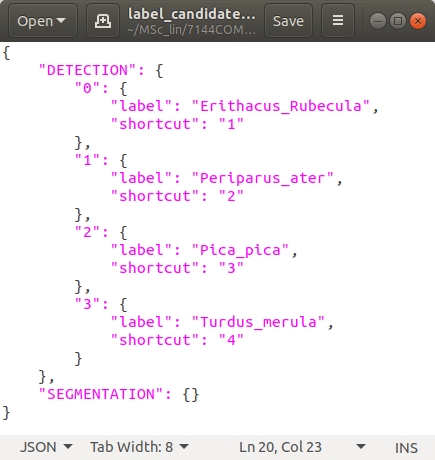

In [9]:
Image(filename = f"{figures_dir}/tagging_labels.png", width = 400)

### <b>5.2 Fix filenames</b>

#### This dataset has a minor issue regarding its filenames which makes 3000 images not being loaded by tagging application because of whitespaces in filenames. Below code will standardize filenames by removing all whitespaces

In [10]:
for filename in os.listdir(data_dir):
    if " " in filename:
        os.rename(os.path.join(data_dir, filename), os.path.join(data_dir, filename.replace(" ", "")))

### <b>5.3 Perform tagging</b>

#### Now lets start ReNomTAG and generate tags for all images.
#### ReNomTag produces XML files which contain information about created bounding boxes for each image.
#### Pascal VOC format is used for this project.

In [11]:
%cd $main_dir
!python -m renom_tag

/home/michal/MSc_lin/7144COMP/Coursework_2
Bottle v0.12.18 server starting up (using WSGIRefServer())...
Listening on http://0.0.0.0:8885/
Hit Ctrl-C to quit.

^C


### Example of the produced tagging data

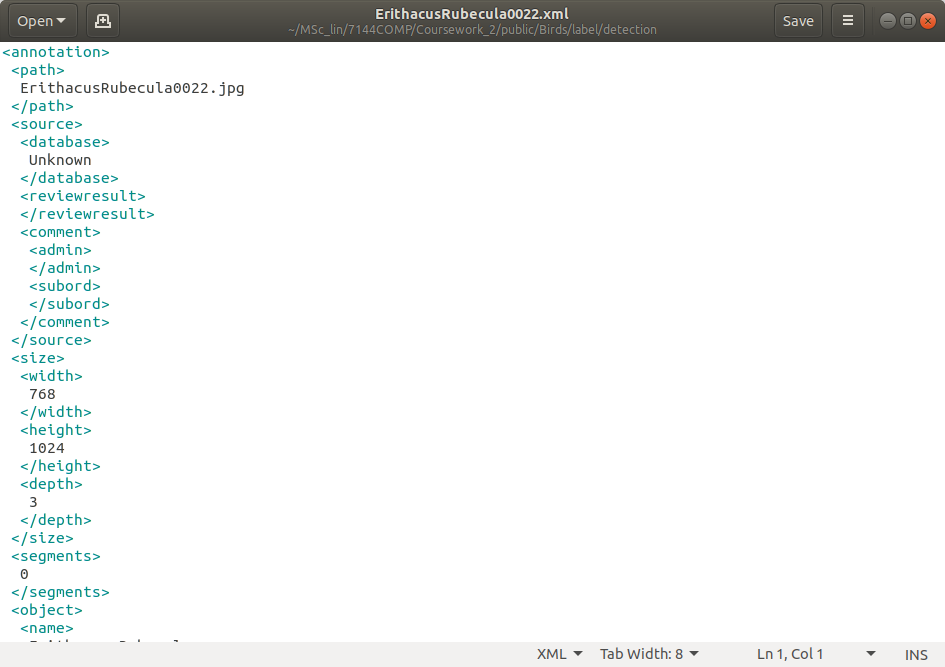

In [12]:
Image(filename = f"{figures_dir}/tag_data.png", width = 600)

## <b>6. Augmentation</b>

### While first training results were very good reaching IoU 0.5 - 0.77 and IoU 0.75 - 0.55 the inference showed that many objects are not being detected. One of the reasons why model may not perform well is lack of input data. Initial tests involved 500 images per class. Later number of images per class was increased to 800, but results did not changed much. Decision of augmentation was made to introduce more variance to the model by feeding it with more information. One of the best augmentation methods is moving image and as a result object as well. There are many techniques that can be used such as rotation, and flipping. However, because these methods result in object being moved it means that tagging must be performed again. It was concluded that flipping allows to calculate new location of the bounding box thus automation of the process is possible. As a result horizontal and vertical flipping were chosen as augmantation methods to be applied.

### The augmentation involves creation of a copy of each original file. As a result dataset includes 1600 images per class with overall number of images in dataset reaching 6400. Horizontal and vertical flipping is applied in a way that at least one method is used on each image. There are 3 different possible result for a new image:
* horizontally flipped
* verticaly flipped
* horizontally and verticaly flipped

### There are 2 important questions that must be answered regarding augmentation. Why not create 3 pictures from each original one where each method is applied? This was tested and results while satisfying, were not as good as with randomised choice of the method. Possibly great amount of flipped images caused model to learn this and made it better at detecting mirrored images instead od detecting birds. While I did not decided to test if that is true this can be one the reasons why models trained on greater datasets where performing worse than when methods are randomized.
### The second question is why am I augmenting images before performing data split? While this is not advisable I decided to do it because flipping image of a bird does not make a bird take an unrealistic pose. Sure if we considered flipping a car horizontally and including it in a dataset that would not be very realistic unless we want to detect flying cars or cars after crash. Variety of poses that bird can take is great thus I decided to increase size of test set as well with augmented images. Morover I tested other option where test set was without augmented images and the results were worse than when augmented images were used in both sets. With all that in mind I would not include augmented images to a test set if other methods were applied. Again while not advisable this method proved to give better performance of the final models thus exception was made.

### New script was created to automate the process of augmentation. Because manual tagging of new images would take a considerable amount of time rotation was abandoned as this method does not allow to calculate a new bounding box. New bounding box values are calculated based on image width and height, original bounding box values and augmentation method applied.

In [22]:
%cd $scripts_dir
!python img_augment.py -i $data_dir -x $detect_dir -o $augment_dir

/home/michal/MSc_lin/7144COMP/Coursework_2/scripts


### Example of augmented image were both flipping methods were applied

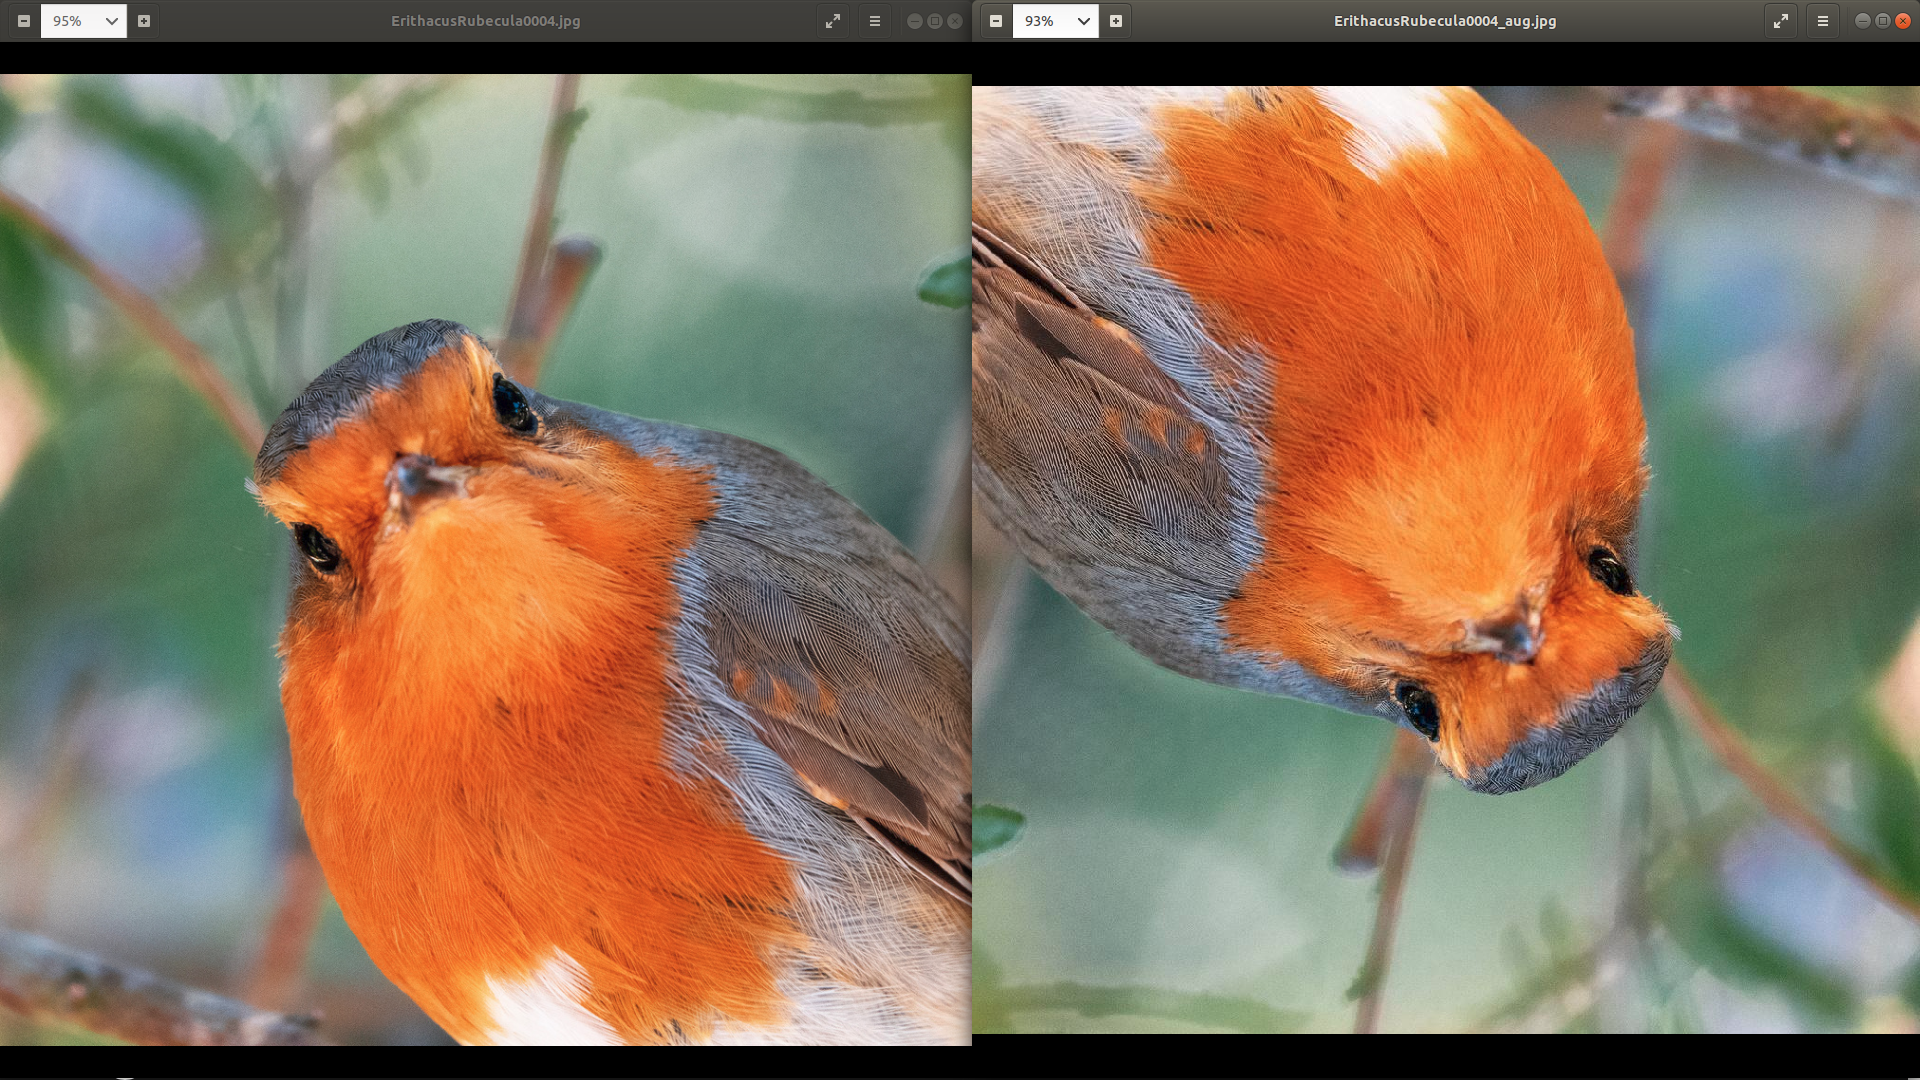

In [23]:
Image(filename = f"{figures_dir}/aug_example.png", width = 800)

## <b>7. Convert XML files</b>

### With all of the tagging and augmentation finished it is now time to convert generated XML files as model will not read them in the current format. For each file we have to remove every whitespace and new lines. The conversion will result in reduction of the content to a single string value. Moreover, the script will create a new folder "cleaned" and place inside newly converted xml files together with their images.
#### xmlconversion.py script will be used to perform the cleaning.

In [28]:
%cd $scripts_dir
!python xmlconversion.py -i $augim_dir -x $augxm_dir -o $work_dir

/home/michal/MSc_lin/7144COMP/Coursework_2/scripts


### XML file after cleaning

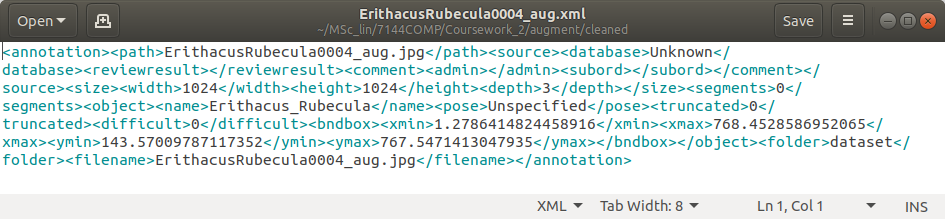

In [29]:
Image(filename = f"{figures_dir}/xml_cleaned.png", width = 600)

### Set path to newly created "cleaned" directory

In [30]:
cleaned_dir = os.path.join(work_dir, "cleaned")

## <b>8. Data split</b>

### Next step is to split the data into train and test sets. To do this we will use another script that will ensure that equal number of images per class is moved to train and test directory. This process is very important as unequal class representation might result in model being biased towards majority classes during training and evaluation.

In [31]:
!python partition_dataset.py -x -i $cleaned_dir -o $work_dir -r 0.1

## <b>9. Create label map</b>

### Now we have to create a label map for a model with all classes previously defined as label candidates. A map will be used by the model to perform training thus we have to make sure that all labels are included.

In [64]:
label_map = os.path.join(work_dir, "label_map.pbtxt")
if os.path.isfile(label_map):
    os.remove(label_map)
lmap = ""
t = "  "
for label in labels:
    lbl = f"item {{\n{t}id: {labels.index(label)+1}\n{t}name: '{label}'\n}}\n"
    lmap = lmap + lbl
with open(label_map, "w") as f:
    f.write(lmap[:-1])

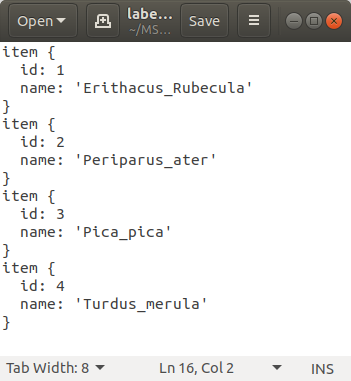

In [33]:
Image(filename = f"{figures_dir}/label_map.png", width = 400)

## <b>10. Generate TFrecord files</b>

### Now it is time to generate TFRecords for train and test sets. These files store sequence of binary records about each file included in train and test sets and they will be used by the model during training and evaluation.

In [34]:
%cd $scripts_dir
!python generate_tfrecord.py -x $work_dir/train -l $work_dir/label_map.pbtxt -o $work_dir/train.record
!python generate_tfrecord.py -x $work_dir/test -l $work_dir/label_map.pbtxt -o $work_dir/test.record

/home/michal/MSc_lin/7144COMP/Coursework_2/scripts
Successfully created the TFRecord file: /home/michal/MSc_lin/7144COMP/Coursework_2/public/Birds/train.record
Successfully created the TFRecord file: /home/michal/MSc_lin/7144COMP/Coursework_2/public/Birds/test.record
